In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.models import Model
np.random.seed(1)

In [2]:
InputPath="custom_lunar_dataset/train/high"

In [3]:
def addNoise(image, salt_prob=0.1, pepper_prob=0.1):
    # Make a copy of the image
    noiseAddedImage = np.copy(image)
    
    # Check if the image is 2D (grayscale) or 3D (RGB)
    if len(image.shape) == 2:
        row, col = image.shape
        channels = 1
    elif len(image.shape) == 3:
        row, col, channels = image.shape
    
    # Add salt noise (white pixels)
    num_salt = np.ceil(salt_prob * image.size)
    salt_coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape]
    noiseAddedImage[salt_coords[0], salt_coords[1]] = 1
    
    # Add pepper noise (black pixels)
    num_pepper = np.ceil(pepper_prob * image.size)
    pepper_coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape]
    noiseAddedImage[pepper_coords[0], pepper_coords[1]] = 0
    
    return noiseAddedImage

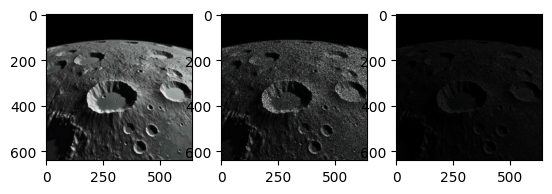

In [4]:
img = cv.imread(InputPath+"/1.jpg")  
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
Noise = addNoise(img)
plt.imshow(Noise)
plt.subplot(1,3,3)
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV) #convert it to hsv
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise2 = addNoise(img1)
plt.imshow(Noise2)

In [5]:
from tqdm import tqdm # for loading bar
HighPath = "custom_lunar_dataset/train/high"

def PreProcessData(ImagePath):
    X_=[]
    y_=[]
    count=0
    for imageName in tqdm(os.listdir(HighPath)):
        count=count+1
        low_img = cv.imread(HighPath + "/" + imageName)
        low_img = cv.cvtColor(low_img, cv.COLOR_BGR2RGB)
        low_img = cv.resize(low_img,(500,500))
        hsv = cv.cvtColor(low_img, cv.COLOR_BGR2HSV) #convert it to hsv
        hsv[...,2] = hsv[...,2]*0.2
        img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
        Noisey_img = addNoise(img_1)
        X_.append(Noisey_img)
        y_.append(low_img)
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_,y_

In [6]:
X_,y_ = PreProcessData(InputPath)

100%|██████████████████████████████████████████████████| 43/43 [00:00<00:00, 145.74it/s]


In [7]:
K.clear_session()

def InstantiateModel(in_):
    
    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)
    
    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_add = add([model_1,model_2,model_2_0])
    
    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)
    
    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)
    
    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)
    
    model_add_2 = add([model_3_1,model_3_2,model_3])
    
    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)

    model_add_3 = add([model_4_1,model_add_2,model_4])
    
    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)
    
    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)
    
    return model_5

In [8]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500, 500,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 500, 500,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 500, 500,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 500, 500,  │      4,640 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 500, 500,  │      8,256 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 500, 500,  │      8,256 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 500, 500,  │     16,448 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 500, 500,  │          0 │ conv2d_2[0][0],   │
│                     │ 64)               │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 500, 500,  │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 500, 500,  │     18,464 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 500, 500,  │     18,464 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 500, 500,  │      2,064 │ conv2d_9[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 500, 500,  │      4,112 │ add[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 500, 500,  │      2,064 │ conv2d_7[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 500, 500,  │          0 │ conv2d_10[0][0],  │
│                     │ 16)               │            │ conv2d_11[0][0],  │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 500, 500,  │      9,232 │ add[0][0]         │
│                     │ 16)               │            │                 

 Total params: 134,067 (523.70 KB)

 Trainable params: 134,067 (523.70 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# training

def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_Enhancer.fit(GenerateInputs(X_,y_),epochs=10,verbose=1,steps_per_epoch=4,shuffle=True) 
#epochs * steps_per_epoch <= training dataset images...

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 9995.2500
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 5895.8032
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 5350.0239
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 4613.4521
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 5098.0923
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 3766.1260
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 3953.3123
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 4059.3284
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 2218.7153
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 2471.7764


In [10]:
TestPath="custom_lunar_dataset/train/high"

In [11]:
def ExtractTestInput(img):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV) #convert it to hsv
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = addNoise(img1)
    Noise = Noise.reshape(1,500,500,3)
    return Noise

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


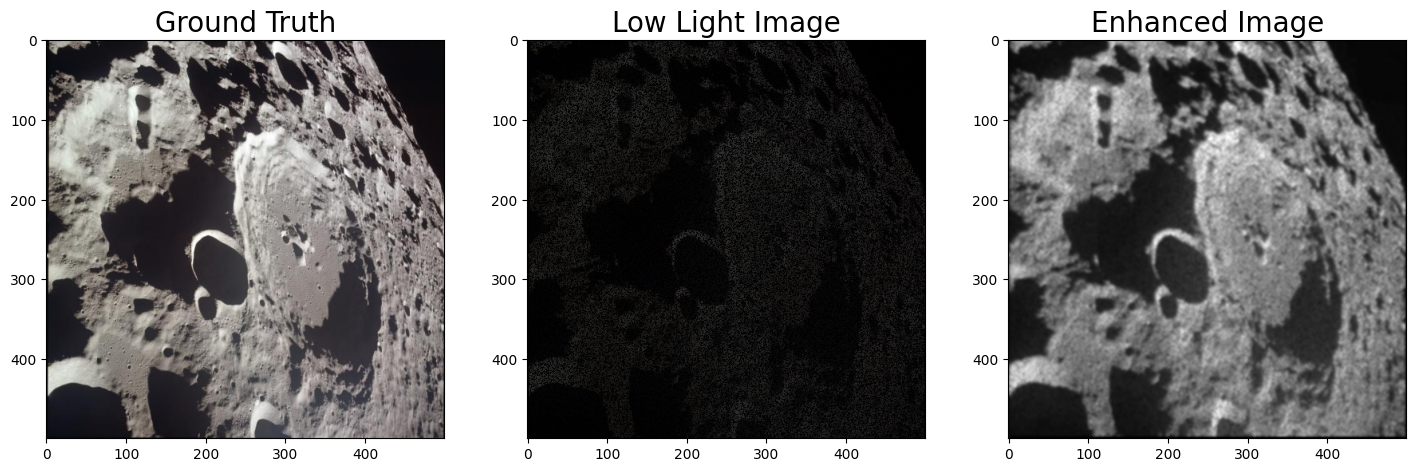

In [15]:
# inference

ImagePath=InputPath+"/2.jpg"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(ImagePath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(ImagePath)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
enhanced_gray = cv.cvtColor(Prediction, cv.COLOR_RGB2GRAY)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(enhanced_gray, cmap='gray')

In [ ]:
# VideoPath = "psr_video_check_2.mp4"
# cap = cv.VideoCapture(VideoPath)

# if not cap.isOpened():
#     print("Error opening video stream or file")

# while cap.isOpened():
#     ret, frame = cap.read()

#     if not ret:
#         break

#     resized_frame = cv.resize(frame, (500, 500))

#     rgb_frame = cv.cvtColor(resized_frame, cv.COLOR_BGR2RGB)

#     # Model Prediction (Enhanced Image)
#     input_frame = rgb_frame.reshape(1, 500, 500, 3)
#     Prediction = Model_Enhancer.predict(input_frame)
#     Prediction = Prediction.reshape(500, 500, 3)

#     cv.imshow('Enhanced Image (RGB)', Prediction.astype(np.uint8))

#     # Convert Enhanced Image to Grayscale
#     enhanced_gray = cv.cvtColor(Prediction, cv.COLOR_RGB2GRAY)

#     cv.imshow("original", rgb_frame)
#     cv.imshow("enhanced", enhanced_gray)
    
#     if cv.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv.waitKey(1)
# cv.destroyAllWindows()
